In [63]:
import pandas as pd
import saspy
import numpy as np

# Exploring the Data

Before we do any model building, we should explore the data to see if we can eliminate any models that we shouldn't be using. We can see the linear regression assumptions to see if a general linear model would be a good fit.

In [69]:
%%SAS
PROC IMPORT DATAFILE='TrainingSet.csv'
out=admpred
dbms=csv
replace
;
run;

;
;


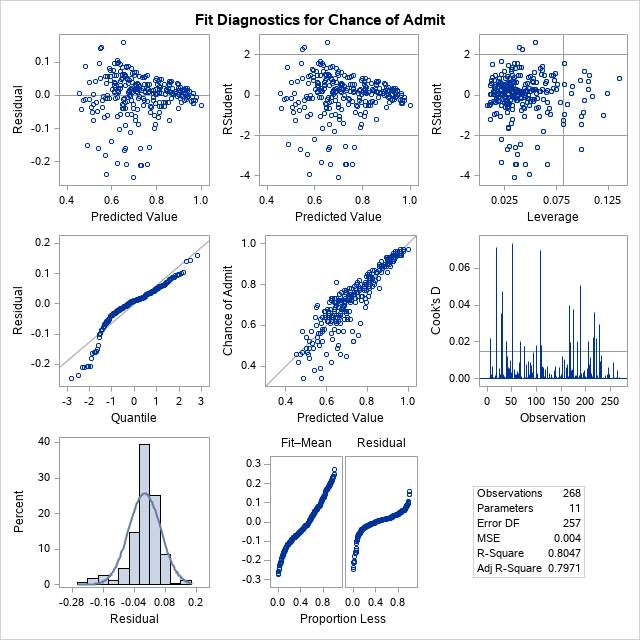

In [70]:
%%SAS
ods graphics on;

proc glm data=admpred plots=Diagnostics;
    class Research;
    model 'Chance of Admit'n='GRE Score'n 'TOEFL Score'n SOP LOR CGPA 'University Rating'n Research 'GRE Score'n * Research 'TOEFL Score'n * Research 'University Rating'n * Research;
run;

# Exploring the Diagnostics

It's not looking good. There are four linear regression assumptions that we look out for:

1) Constant variance (Homoskedasticity)
2) Expected value of residuals is 0
3) Residuals are independent
4) Residuals are normally distributed.

The first assumption of homoskedasticity is evidently violated. By observing the Residuals vs Predicted Value plot, there is a cone-like pattern in the data. We expect this to be randomly distributed, similar to a random scatter plot, in order to maintain the constant variance assumption. We also expect the same pattern for the second assumption. The latter two assumptions follow a similar fate as the former two; the Residual vs Quantile Plot informs us about the normalcy of the distribution of the data, the closer the points hug the line the more normal the residuals are.


# Variance Stabilizing Transformation


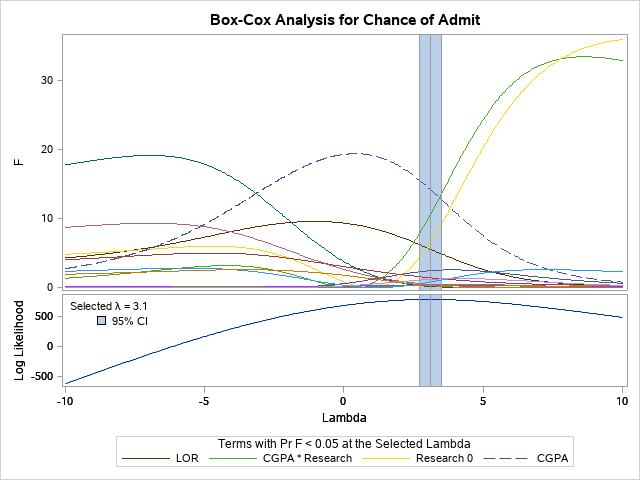
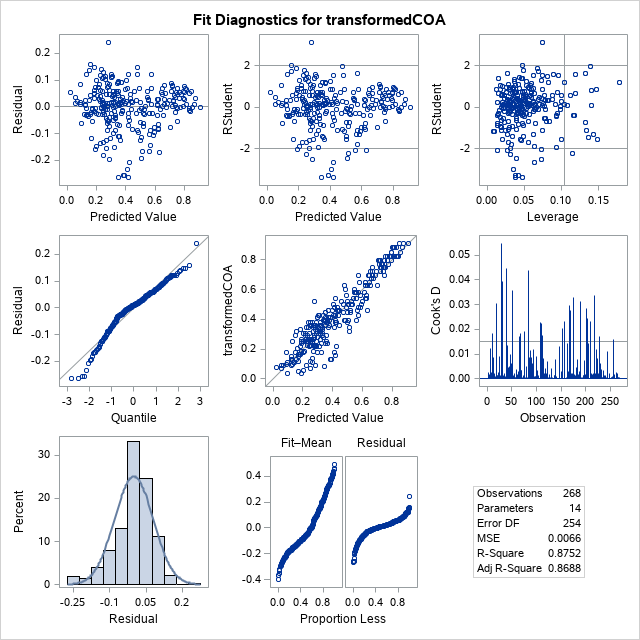

In [72]:
%%SAS
/* BOX COX TRANSFORMATION PROC TRANSREG */
TITLE "Box Cox Transformation -- Admission Prediction Data";
proc transreg data=admpred plots=boxcox;
model boxcox('Chance of Admit'n / lambda=-10 to 10 by 0.05) = identity('GRE Score'n) identity('TOEFL Score'n) identity(SOP) identity(LOR) identity('University Rating'n) identity('GRE Score'n * Research) identity('TOEFL Score'n * Research) identity(SOP * Research) identity(LOR * Research) identity(CGPA * Research) identity('University Rating'n * Research) class(Research / effects) identity(CGPA);
output coefficients replace;
run;

/* Transforming Chance_of_Admit and building another model with the respective transformation. */
data admpredmodif; set admpred;
transformedCOA = ('Chance of Admit'n ** 3.1);
run;

TITLE "Multiple Linear Regression -- Admission Prediction Data";
PROC GLM DATA=admpredmodif plots=(DIAGNOSTICS);
class Research;
model transformedCOA = 'GRE Score'n 'TOEFL Score'n SOP LOR CGPA 'University Rating'n Research 'GRE Score'n * Research 'TOEFL Score'n * Research SOP * Research LOR * Research CGPA * Research 'University Rating'n * Research
;

run;